In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2   # ✅ mysql.connector এর বদলে

# PostgreSQL connection
db = psycopg2.connect(
    host     = "localhost",
    user     = "postgres",   # default username
    password = "uweria123",
    dbname   = "ecommerce"   # database parameter name is `dbname`
)

cur = db.cursor()
   

list all unique cities where customers are located

In [2]:
query = '''select customer_city from customers;'''
cur.execute(query) 
data = cur.fetchall()
df =pd.DataFrame(data)
df.head()

,0
0,sao paulo
1,alambari
2,paracatu
3,sao bento do sul
4,iguape


#  2. Count the number of orders placed in 2017.


In [3]:
query = """
    SELECT COUNT(order_id)
    FROM orders
    WHERE EXTRACT(YEAR FROM order_purchase_timestamp::timestamp) = 2017;
"""
cur.execute(query)
data = cur.fetchone()

print("Total orders placed in 2017 are", data[0])



Total orders placed in 2017 are 451010


# Find the total sales per category.

In [4]:
query = """
    SELECT UPPER(products.product_category) AS category,
           ROUND(SUM(payments.payment_value)::numeric, 2) AS sales
    FROM products
    JOIN order_items 
        ON products.product_id = order_items.product_id
    JOIN payments 
        ON payments.order_id = order_items.order_id
    GROUP BY category;
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Category", "Sales"])
df.tail(22)


,Category,Sales
52,IMPORTED BOOKS,428924.00
53,INDUSTRY COMMERCE AND BUSINESS,3631750.00
54,INSURANCE AND SERVICES,20768.60
55,KITCHEN PORTABLE AND FOOD COACH,277482.00
56,LA CUISINE,186466.00
57,MARKET PLACE,2901490.00
58,MUSICAL INSTRUMENTS,14916400.00
59,PARTY ARTICLES,381844.00
60,PC GAMER,139164.00
61,PCS,17863800.00


# Calculate the percentage of orders that were paid in installments.

In [5]:
query = """
    SELECT 
        (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END)::numeric 
         / COUNT(*)::numeric) * 100
    AS installment_percentage
    FROM payments;
"""
cur.execute(query)
data = cur.fetchone()

print("The percentage of orders that were paid in installments is", data[0])


The percentage of orders that were paid in installments is 99.99807481277554242200


# Count the number of customers from each state.

Text(0.5, 1.0, 'count of customers by state')

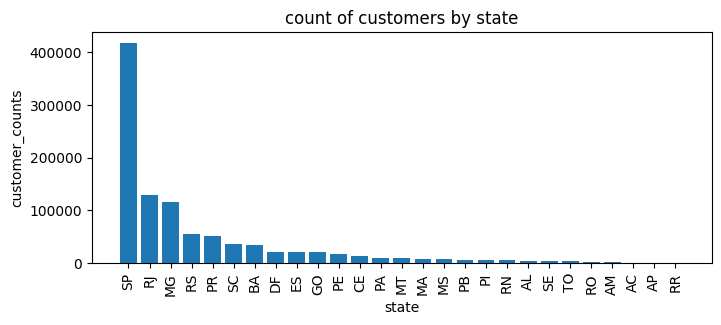

In [6]:

quer = ''' select customer_state ,count(customer_id)
from customers group by customer_state;
'''

cur.execute(quer)

data = cur.fetchall()
df = pd.DataFrame(data,columns=['state','customer_counts'])
df = df.sort_values(by = 'customer_counts',ascending= False)
plt.figure(figsize=(8,3)) 
plt.bar(df['state'],df['customer_counts'])
plt.xticks(rotation = 90) 
plt.xlabel('state') 
plt.ylabel('customer_counts') 
plt.title("count of customers by state") 

# Calculate the number of orders per month in 2018.

[Text(0, 0, '72690'),
 Text(0, 0, '67280'),
 Text(0, 0, '72110'),
 Text(0, 0, '69390'),
 Text(0, 0, '68730'),
 Text(0, 0, '61670'),
 Text(0, 0, '62920'),
 Text(0, 0, '65120'),
 Text(0, 0, '160'),
 Text(0, 0, '40')]

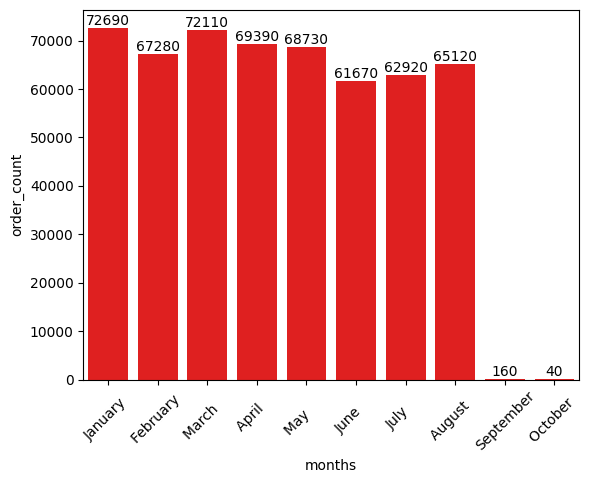

In [7]:
query = """
SELECT 
    TO_CHAR(order_purchase_timestamp::timestamp, 'Month') AS months,
    COUNT(order_id) AS order_count
FROM orders
WHERE EXTRACT(YEAR FROM order_purchase_timestamp::timestamp) = 2018
GROUP BY months, DATE_PART('month', order_purchase_timestamp::timestamp)
ORDER BY DATE_PART('month', order_purchase_timestamp::timestamp);
"""

cur.execute(query) 
data = cur.fetchall() 
df = pd.DataFrame(data,columns= ['months','order_count']) 
df.head()
ax = sns.barplot(x=df['months'], y  = df['order_count'], data = df,color= 'red')
plt.xticks(rotation = 45) 
ax.bar_label(ax.containers[0]) 

# Find the average number of products per order, grouped by customer city.

In [8]:
# query = '''with count_per_order as
# (select orders.order_id,orders.customer_id,count(order_items.order_id) as oc 
# from orders join order_items
# on orders.order_id = order_items.order_id
# group  by orders.order_id,orders.customer_id) 

# select customers.customer_city,round(avg(count_per_order.oc),2) average_order
# from customers join count_per_order
# on customers.customer_id = count_per_order.customer_id
# group by customers.customer_city order by average_order desc '''

query = '''
WITH count_per_order AS (
    SELECT 
        orders.order_id,
        orders.customer_id,
        COUNT(order_items.order_id) AS oc
    FROM orders 
    JOIN order_items
        ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT 
    customers.customer_city,
    ROUND(AVG(count_per_order.oc)::numeric, 2) AS average_order
FROM customers 
JOIN count_per_order
    ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city 
ORDER BY average_order DESC;
'''




cur.execute(query) 
data  = cur.fetchall() 
df = pd.DataFrame(data,columns=['customer_city','avarage_product/order']) 

df.head(10)

,customer_city,avarage_product/order
0,padre carvalho,280.00
1,celso ramos,260.00
2,candido godoi,240.00
3,datas,240.00
4,matias olimpio,200.00
5,cidelandia,160.00
6,teixeira soares,160.00
7,picarra,160.00
8,curralinho,160.00
9,morro de sao paulo,160.00


 # Calculate the percentage of total revenue contributed by each product category.

In [9]:
query = '''SELECT 
    UPPER(products.product_category) AS category, 
    ROUND(
        (SUM(payments.payment_value)::numeric 
        / (SELECT SUM(payment_value) FROM payments)::numeric) * 100
    , 2) AS sales_percentage
FROM products 
JOIN order_items 
    ON products.product_id = order_items.product_id
JOIN payments 
    ON payments.order_id = order_items.order_id
GROUP BY category 
ORDER BY sales_percentage DESC''' 

cur.execute(query) 
data = cur.fetchall() 
df = pd.DataFrame(data, columns=['product_category','percentage']) 
df.head()


,product_category,percentage
0,BED TABLE BATH,171.17
1,HEALTH BEAUTY,165.64
2,COMPUTER ACCESSORIES,158.45
3,FURNITURE DECORATION,142.93
4,WATCHES PRESENT,142.84


# Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
query = ''' select products.product_category,count(order_items.order_id),
ROUND(AVG(order_items.price)::numeric,2) average_counts
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;'''


cur.execute(query) 
data = cur.fetchall() 
df = pd.DataFrame(data, columns=['product_catagory','counts', 'average'])

df.head()

,product_catagory,counts,average
0,Agro Industria e Comercio,3392,342.12
1,Art,3344,115.80
2,Arts and Crafts,384,75.58
3,audio,5824,139.25
4,automotive,67760,139.96


In [11]:
cur.execute(query) 
data = cur.fetchall() 

df = pd.DataFrame(data, columns=['product_category','counts', 'average'])

counts = df['counts'].astype(float)
average = df['average'].astype(float)

a = np.corrcoef(counts, average)

print("correlation =", a[0][-1])


correlation = -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [12]:
query = '''SELECT *, 
       DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn 
FROM (
    SELECT order_items.seller_id, 
           SUM(payments.payment_value) revenue 
    FROM order_items 
    JOIN payments
      ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a; '''
cur.execute(query) 
data = cur.fetchall() 
df = pd.DataFrame(data,columns=['seller_id','revenue','ranking']) 
df.head()


,seller_id,revenue,ranking
0,7c67e1448b00f6e969d365cea6b010ab,8114637.0,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,4931549.0,2
2,4a3ca9315b744ce9f8e9374361493884,4819834.5,3
3,1f50f920176fa81dab994f9023523100,4644015.0,4
4,53243585a1d6dc2643021fd1853d8905,4558435.5,5


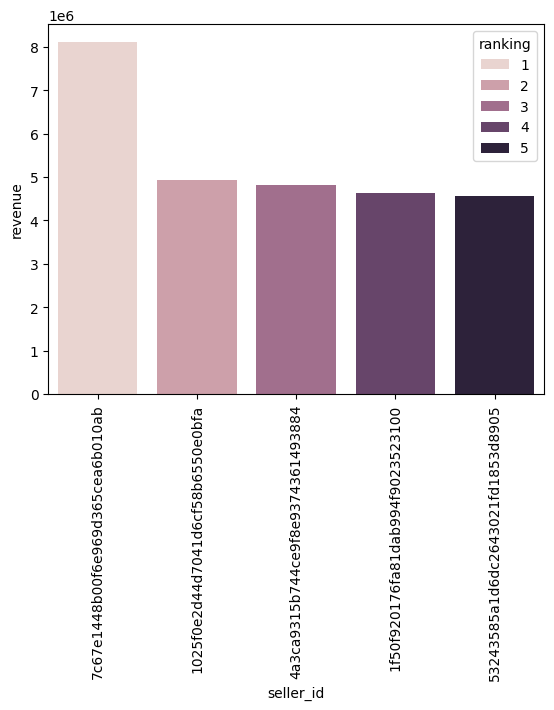

In [13]:
query = '''SELECT *, 
       DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn 
FROM (
    SELECT order_items.seller_id, 
           SUM(payments.payment_value) revenue 
    FROM order_items 
    JOIN payments
      ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a; '''
cur.execute(query) 
data = cur.fetchall() 
df = pd.DataFrame(data,columns=['seller_id','revenue','ranking']) 
df = df.head()
sns.barplot(x = 'seller_id', y= 'revenue', hue='ranking',data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [14]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query) 
data = cur.fetchall() 
df = pd.DataFrame(data,columns=['customar_is','timestemp','payment','mov_avg'])
df.head()

,customar_is,timestemp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998


# Calculate the cumulative sales per month for each year.

In [15]:
query = """
SELECT years,
       months,
       payment,
       SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales 
FROM (
    SELECT 
        EXTRACT(YEAR FROM orders.order_purchase_timestamp::timestamp) AS years,
        EXTRACT(MONTH FROM orders.order_purchase_timestamp::timestamp) AS months,
        ROUND(SUM(payments.payment_value)::numeric, 2) AS payment
    FROM orders 
    JOIN payments
      ON orders.order_id = payments.order_id
    GROUP BY years, months
    ORDER BY years, months
) AS a;
"""
cur.execute(query) 
data = cur.fetchall() 
df = pd.DataFrame(data, columns=['years','months','payments','comnulativ_salse'])
df.head(33)

,years,months,payments,comnulativ_salse
0,2016,9,10089.60,10089.60
1,2016,10,2363610.00,2373699.60
2,2016,12,784.80,2374484.40
3,2017,1,5539510.00,7913994.40
4,2017,2,11676200.00,19590194.40
5,2017,3,17994500.00,37584694.40
6,2017,4,16711400.00,54296094.40
7,2017,5,23716400.00,78012494.40
8,2017,6,20450500.00,98462994.40
9,2017,7,23695100.00,122158094.40


# Calculate the year-over-year growth rate of total sales.

In [16]:
query = ''' 
WITH a AS (
    SELECT 
        EXTRACT(YEAR FROM orders.order_purchase_timestamp::timestamp) AS years,
        ROUND(SUM(payments.payment_value)::numeric, 2) AS payment
    FROM orders
    JOIN payments
        ON orders.order_id = payments.order_id
    GROUP BY years
    ORDER BY years
)
SELECT 
    years,
    ((payment - LAG(payment, 1) OVER (ORDER BY years)) 
     / LAG(payment, 1) OVER (ORDER BY years)) * 100 
     AS growth_percentage
FROM a;

'''
cur.execute(query) 
data = cur.fetchall() 
df = pd.DataFrame(data, columns=['years','growth/percengate']) 
df.head(33) 

,years,growth/percengate
0,2016,None
1,2017,12112.3066426895880800
2,2018,19.99896544589282019400


In [17]:
query = '''SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers
    JOIN orders
        ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ['customer_id','first_order'])
df.head()

,customer_id,first_order
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17


# Identify the top 3 customers who spent the most money in each year.

In [18]:
query = '''
select years, customer_id, payment, d_rank
from
(select extract(year from orders.order_purchase_timestamp::timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by extract (year from orders.order_purchase_timestamp::timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by extract(year from orders.order_purchase_timestamp::timestamp),
orders.customer_id) as a
where d_rank <= 3 ;'''
cur.execute(query) 
data = cur.fetchall() 
data

[(Decimal('2016'), 'a9dc96b027d1252bbac0a9b72d837fc6', 56942.02, 1),
 (Decimal('2016'), '1d34ed25963d5aae4cf3d7f3a4cda173', 56029.574, 2),
 (Decimal('2016'), '4a06381959b6670756de02e07b83815f', 49111.21, 3),
 (Decimal('2017'), '1617b1357756262bfa56ab541c47bc16', 546563.44, 1),
 (Decimal('2017'), 'c6e2731c5b391845f6800c97401a43a9', 277172.47, 2),
 (Decimal('2017'), '3fd6777bbce08a352fddd04e4a7cc8f6', 269066.3, 3),
 (Decimal('2018'), 'ec5b2ba62e574342386871631fafd3fc', 290995.12, 1),
 (Decimal('2018'), 'f48d464a0baaea338cb25f816991ab1f', 276888.3, 2),
 (Decimal('2018'), 'e0a2412720e9ea4f26c1ac985f6a7358', 192377.55, 3)]

In [19]:
query = '''
WITH a AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp)::timestamp AS first_order
    FROM customers
    JOIN orders
        ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),

b AS (
    SELECT 
        a.customer_id, 
        COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a
    JOIN orders
        ON orders.customer_id = a.customer_id
       AND orders.order_purchase_timestamp::timestamp > a.first_order
       AND orders.order_purchase_timestamp::timestamp < (a.first_order + INTERVAL '6 months')
    GROUP BY a.customer_id
)

SELECT 
    100 * (COUNT(DISTINCT a.customer_id)::numeric / COUNT(DISTINCT b.customer_id)) AS repeat_rate_percentage
FROM a
LEFT JOIN b 
    ON a.customer_id = b.customer_id;'''
cur.execute(query)
data = cur.fetchall()
data

DivisionByZero: division by zero


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.